In [2]:
#https://www.youtube.com/watch?v=mmQ4TTa0LSo
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)



     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ---------------------------------------- 60.4/60.4 kB 3.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/46.2 MB 5.1 MB/s eta 0:00:10
   ---------------------------------------- 0.1/46.2 MB 5.1 MB/s eta 0:00:10
   ---------------------------------------- 0.1/46.2 MB 5.1 MB/s eta 0:00:10
   ---------------------------------------- 0.1/46.2 MB 5.1 MB/s eta 0:00:10
   ---------------------------------------- 0.1/46.2 MB 5.1 MB/s eta 0:00:10
   ---------------------------------------- 0.1/46.2 MB 5.1 MB/s eta 0:00:10
   ---------------------------------------- 0.1/46.2 MB 5.1 MB/s eta 0:00:10
   ---------------------------------------- 0.3/46.2 MB 737.3 kB/s eta 0:01:03
   ---------------------------------------- 0.3/46.2 MB 791.9 kB/s eta 0:00:58
   ---------------------------------------- 0.3/46.2 MB 791.9 kB/s eta 0:00:58
  

In [3]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

# Data Preparation

For this implementation, we’ll be using the Fashion-MNIST dataset - a collection of grayscale images of clothing items, each of size 28x28 pixels. (show img from internet)

In [6]:

 (x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()


4422102/4422102 [==============================] - 0s 0us/step


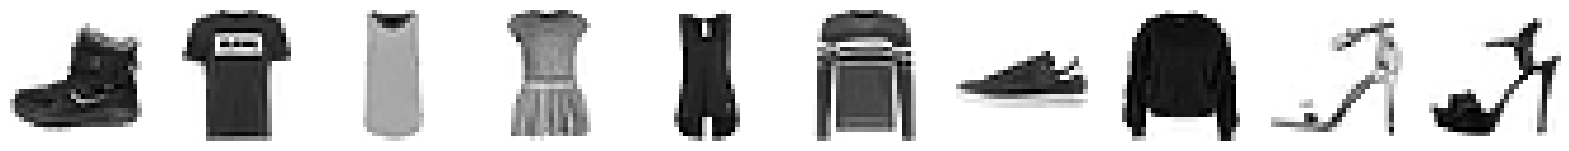

In [7]:
display(x_train)

These images are originally 28 x 28 in grayscale with pixel values ranging from 0 to 255. To make them suitable for our network, we'll preprocess them by scaling the pixel values to be between 0 and 1. Additionally, we'll pad the images to a size of 32 x 32 to simplify how we work with the data as it goes through the network.

## Data Preprocessing

In [21]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

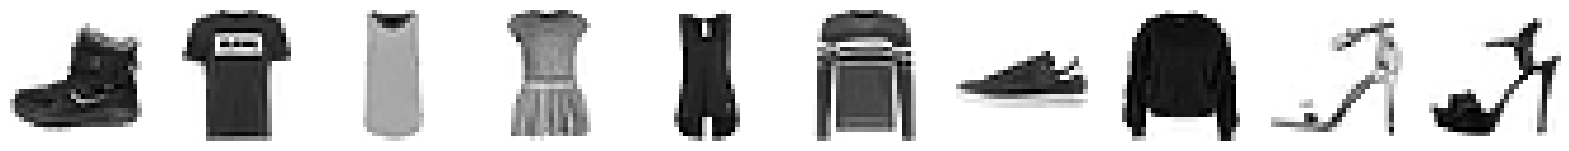

In [8]:
display(x_train)

# Designing and Building Variational Autoencoder

First, we need to create a new Sampling layer for sampling from the distribution defined by z_mean and z_log_var.

In [9]:
#Sampling Layer to calculate z=mean + SD*Epsilon

class Sampling(layers.Layer):
    #We create a new layer by subclassing the keras base Layer
    def call(self, inputs):
        #
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
# Encoder

image_size = 32
embed_dim = 2 # dimension for mean and SD
encoder_input = layers.Input(
    shape=(image_size, image_size, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)

#Instead of connecting the Flatten layer directly to the 2D latent space,
#we will connect it to layers z_mean and z_log_var.
z_mean = layers.Dense(embed_dim, name="z_mean")(x)
z_log_var = layers.Dense(embed_dim, name="z_log_var")(x)

#The Sampling layer samples a point z in the latent space from the
#normal distribution defined by the parameters z_mean and z_log_var.
z = Sampling()([z_mean, z_log_var])

#The Keras Model that defines the encoder—a model that takes an input
#image and outputs z_mean, z_log_var and a sampled point z from the
#normal distribution defined by these parameters.
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                           

In [11]:
# Decoder
decoder_input = layers.Input(shape=(embed_dim,), name="decoder_input")# get latent space vector
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)# flatten and then upsampling
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464 

# Lets Train our Variational Autoencoder

In [9]:
#To create the VAE model, we extend the Keras Model class, enabling us to incorporate the KL divergence calculation
#into a custom train_step method.

In [32]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            #TensorFlow's Gradient Tape helps calculate gradients during a forward pass.
            #To use it, we need wrap the code that performs the operations you want to differentiate within a tf.GradientTape() context.
            #After recording the operations, we can compute the gradient of the loss function concerning certain variables using tape.gradient().
            #These gradients are then used to update the variables with the optimizer.

            z_mean, z_log_var, reconstruction = self(data)
            beta = 500
            reconstruction_loss = tf.reduce_mean(
                beta
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        beta = 500
        reconstruction_loss = tf.reduce_mean(
            beta
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [33]:
vae = VAE(encoder, decoder)

# Starting Training

In [34]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [35]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [36]:
vae.fit(
    x_train,
    epochs=5,
    batch_size=50,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback]
)

Epoch 1/5


ValueError: in user code:

    File "C:\Python\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Python\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Python\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\admin\AppData\Local\Temp\ipykernel_12644\2591331651.py", line 34, in train_step
        z_mean, z_log_var, reconstruction = self(data)
    File "C:\Python\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\admin\AppData\Local\Temp\__autograph_generated_filendvv5isj.py", line 11, in tf__call
        (z_mean, z_log_var, z) = ag__.converted_call(ag__.ld(encoder), (ag__.ld(inputs),), None, fscope)

    ValueError: Exception encountered when calling layer 'vae_3' (type VAE).
    
    in user code:
    
        File "C:\Users\admin\AppData\Local\Temp\ipykernel_12644\2591331651.py", line 22, in call  *
            z_mean, z_log_var, z = encoder(inputs)
        File "C:\Python\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Python\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
            raise ValueError(
    
        ValueError: Input 0 of layer "encoder" is incompatible with the layer: expected shape=(None, 32, 32, 1), found shape=(50, 28, 28)
    
    
    Call arguments received by layer 'vae_3' (type VAE):
      • inputs=tf.Tensor(shape=(50, 28, 28), dtype=uint8)


# Lets try to reconstruct using our trained variational autoencoder

In [29]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 4ms/step
Example real clothing items


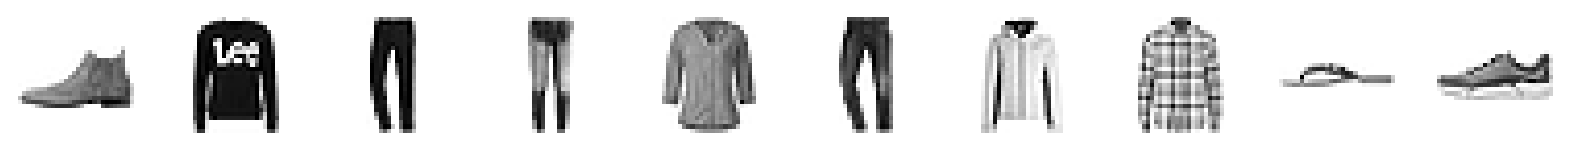

Reconstructions


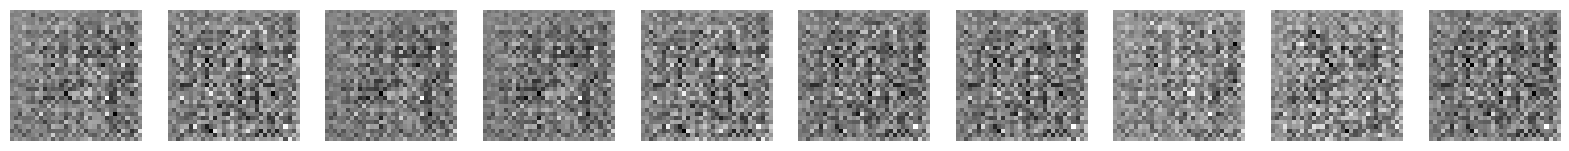

In [28]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

# Lets visualize Latent Space

In [30]:
z_mean, z_var, z = encoder.predict(example_images)
p = norm.cdf(z)

ValueError: in user code:

    File "C:\Python\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Python\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Python\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Python\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Python\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Python\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "encoder" is incompatible with the layer: expected shape=(None, 32, 32, 1), found shape=(None, 28, 28)


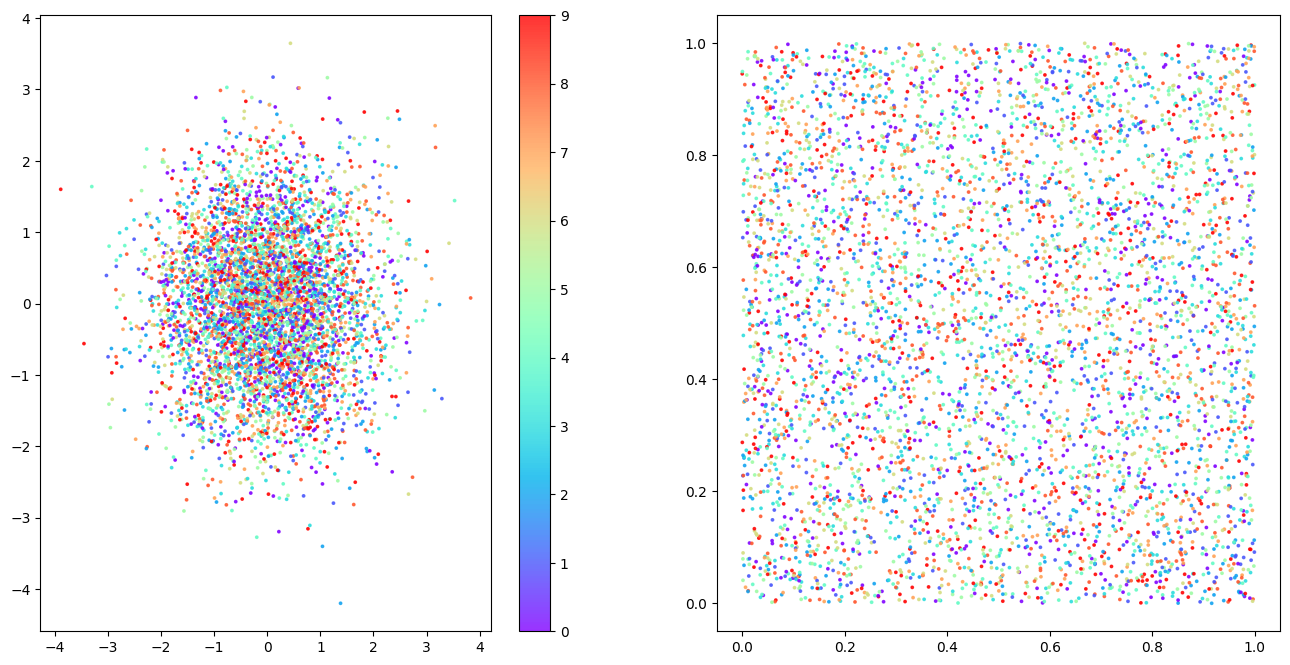

In [32]:



figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

Firstly, the KL divergence loss term keeps z_mean and z_log_var values close to a standard normal distribution. Secondly, the stochastic encoder leads to a more continuous latent space, reducing the occurrence of poorly formed images.


Finally, when we color-code points in the latent space by clothing type, we observe that there is no bias favoring any specific type. The right-hand plot displays the space converted into p-values, revealing nearly equal representation for each color. It's crucial to emphasize that the model learned clothing distinctions independently, without using labels during training, to minimize reconstruction loss.